In [ ]:
!pip install mecab-python3

In [ ]:
!pip install unidic
!python -m unidic download

download url: https://cotonoha-dic.s3-ap-northeast-1.amazonaws.com/unidic-3.1.0.zip
Dictionary version: 3.1.0+2021-08-31
unidic-3.1.0.zip: 100% 526M/526M [01:39<00:00, 5.28MB/s]
Finished download.
Downloaded UniDic v3.1.0+2021-08-31 to /usr/local/lib/python3.10/dist-packages/unidic/dicdir


In [ ]:
!pip install sentence-transformers

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
import os
import re
import pandas as pd
import unicodedata
from IPython.display import display

# CSVファイルの読み込み
text_file_path = "/content/drive/MyDrive/merged_df2_v3.csv"  # アップロードしたファイルのパス
stock_file_path = "/content/drive/MyDrive/yfinance_csvfile/df_savedyfinance13.csv"
text_df = pd.read_csv(text_file_path)
text_df = text_df.head(200)
stock_df = pd.read_csv(stock_file_path)

# 必要な列を確認して事業内容と経営方針を取得
display(text_df.columns)  # 列名を確認
display(stock_df.columns)

# 欠損値を削除
text_df = text_df.dropna(subset=['事業の内容', '経営方針','証券コード'])

# 証券コードを整数型に変換
text_df['証券コード'] = text_df['証券コード'].astype(int)

# 証券コードの末尾に"0"を追加
stock_df["証券コード"] = stock_df["証券コード"].astype(str) + "0"

# 事業内容と経営方針を一つのテキストとして結合
text_df['テキスト'] = text_df['事業の内容'] + " " + text_df['経営方針']

#書類名、docID、EDINETコード、決算期、事業の内容、経営方針のカラムを削除
text_df = text_df.drop(columns=['書類名','docID', 'ＥＤＩＮＥＴコード', '決算期', '事業の内容', '経営方針'])

display(text_df.head())
display(stock_df.head())

Index(['会社名', '書類名', 'docID', '証券コード', 'ＥＤＩＮＥＴコード', '決算期', '提出日', '提出者業種',
       '事業の内容', '経営方針'],
      dtype='object')

Index(['証券コード', '日付', '調整済み終値'], dtype='object')

,会社名,証券コード,提出日,提出者業種,テキスト
0,株式会社長府製作所,59460,2023-03-30,金属製品,３【事業の内容】当社グループは、当社及び連結子会社３社（㈱大阪テクノクラート、㈱インサイトエ...
1,江崎グリコ株式会社,22060,2023-03-30,食料品,３【事業の内容】当社グループは、当社並びに子会社26社及び関連会社３社により構成されており、...
2,ロイヤルホールディングス株式会社,81790,2023-03-30,小売業,３【事業の内容】当社グループ（当社及び当社の関係会社）は、当社、子会社７社及び関連会社３社で...
3,清和中央ホールディングス株式会社,75310,2023-03-30,卸売業,３ 【事業の内容】当社グループは、持株会社としての当社と、事業会社としての連結子会社４社及び...
7,不二精機株式会社,64000,2023-03-30,機械,３【事業の内容】当社グループは、当社及び連結子会社５社により構成されており、主にプラスチック...


,証券コード,日付,調整済み終値
0,59460,2023-03-31,2133.523438
1,59460,2023-04-03,2164.207764
2,59460,2023-04-05,2139.276611
3,59460,2023-04-07,2122.016846
4,59460,2023-04-10,2134.482178


In [ ]:
def clean_text(text):
    """
    テキストから不要な文字や記号を削除し、整形する関数。
    """
    # 章番号や記号（例: "３ 【事業の内容】" や "１ 【経営方針】"）を削除
    text = re.sub(r'\d+\s*【.*?】', '', text)

    #Unicode正規化
    text = unicodedata.normalize('NFKC', text)
    # 余分な空白や改行を削除
    #text = re.sub(r'\s+', ' ', text)
    #・,「」,()を削除
    text = re.sub('・', '', text)
    text = re.sub('「', '', text)
    text = re.sub('」', '', text)
    text = re.sub(r'\(', '（', text)
    text = re.sub(r'\)', '）', text)
    #(株)→株式会社
    text = text.replace('（株）', '株式会社')
    # 丸括弧で囲まれた番号を削除（例: "(１)"）
    text = re.sub(r'（\d+）', '', text)
    text = re.sub('（', '', text)
    text = re.sub('）', '', text)
    text = re.sub('〔', '', text)
    text = re.sub('〕', '', text)
    text = re.sub(r'\.', '', text)
    text = re.sub(r'『', '', text)
    text = re.sub(r'』', '', text)
    text = re.sub(r'《', '', text)
    text = re.sub(r'》', '', text)
    # 連続するピリオドを削除
    #text = re.sub(r'\.{2,}', '', text)
    # ダブルクオーテーションを削除
    #text = text.replace('"', '')


    # 前後の空白を削除
    return text.strip()

# "事業の内容" と "経営方針" カラムに対して再クリーンアップを適用
text_df['テキスト'] = text_df['テキスト'].apply(clean_text)

# 再度確認用に最初の数行を表示
text_df[['会社名','テキスト']].head()


,会社名,テキスト
0,株式会社長府製作所,当社グループは、当社及び連結子会社3社株式会社大阪テクノクラート、株式会社インサイトエナジー...
1,江崎グリコ株式会社,当社グループは、当社並びに子会社26社及び関連会社3社により構成されており、主として食料品製...
2,ロイヤルホールディングス株式会社,当社グループ当社及び当社の関係会社は、当社、子会社7社及び関連会社3社で構成され、外食事業、...
3,清和中央ホールディングス株式会社,当社グループは、持株会社としての当社と、事業会社としての連結子会社4社及び非連結子会社1社で...
7,不二精機株式会社,当社グループは、当社及び連結子会社5社により構成されており、主にプラスチックを加工するための...


In [ ]:
# データの整形
def reshape_stock_df(tickers, days=180):
    # ティッカーごとに180日分の株価を1行にまとめる
    reshaped_data = stock_df.groupby("証券コード", sort=False)["調整済み終値"].apply(list).reset_index()

    # 列名を作成
    reshaped_data[["Close_" + str(i + 1) for i in range(days)]] = pd.DataFrame(
        reshaped_data["調整済み終値"].tolist(), index=reshaped_data.index
    )
    reshaped_data.drop(columns=["調整済み終値"], inplace=True)  # 元のリスト列を削除

    return reshaped_data

tickers = stock_df["証券コード"].unique()
reshaped_data = reshape_stock_df(tickers)
display(reshaped_data)

<ipython-input-29-b77a9b7c382b>:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  reshaped_data[["Close_" + str(i + 1) for i in range(days)]] = pd.DataFrame(
<ipython-input-29-b77a9b7c382b>:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  reshaped_data[["Close_" + str(i + 1) for i in range(days)]] = pd.DataFrame(
<ipython-input-29-b77a9b7c382b>:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once u

,証券コード,Close_1,Close_2,Close_3,Close_4,Close_5,Close_6,Close_7,Close_8,Close_9,...,Close_171,Close_172,Close_173,Close_174,Close_175,Close_176,Close_177,Close_178,Close_179,Close_180
0,59460,2133.523438,2164.207764,2139.276611,2122.016846,2134.482178,2167.084473,2190.097656,2190.097656,2202.562988,...,2099.250244,2101.205811,2136.405029,2113.916748,2104.139160,2102.183594,2166.715820,2121.738770,2155.960449,2170.626709
1,22060,3203.312012,3265.745117,3251.337402,3246.534912,3241.732422,3212.916992,3236.929932,3232.127441,3270.547852,...,4074.256592,4120.310059,4065.437500,4062.498291,4083.074951,4121.289551,4135.007812,4086.014893,4094.833496,4146.766113
2,81790,2732.547607,2714.899414,2659.993408,2665.876221,2684.504883,2685.485352,2734.508545,2737.449951,2720.781982,...,2604.385986,2591.536865,2597.467285,2599.444092,2591.536865,2564.850586,2511.478027,2536.187500,2521.361816,2546.071289
3,75310,1643.164307,1635.339722,1595.238770,1737.059448,1737.059448,1737.059448,1737.059448,1737.059448,1638.274048,...,1514.590942,1484.931885,1484.931885,1483.943237,1482.954590,1481.965942,1482.954590,1461.204590,1461.204590,1453.295410
4,64000,319.373444,320.321167,320.321167,318.425781,312.739594,314.634979,320.321167,319.373444,320.321167,...,296.806854,297.776825,299.716736,300.686676,299.716736,298.746765,297.776825,296.806854,295.836914,299.716736
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74,65730,71.666664,69.666664,66.666664,67.000000,67.000000,69.666664,71.333336,81.000000,81.000000,...,111.000000,106.000000,106.000000,106.000000,113.000000,107.000000,107.000000,105.000000,103.000000,105.000000
75,45760,214.000000,213.000000,211.000000,204.000000,209.000000,212.000000,218.000000,221.000000,220.000000,...,91.000000,89.000000,90.000000,90.000000,91.000000,93.000000,91.000000,95.000000,90.000000,92.000000
76,97020,1127.456299,1143.415161,1113.374878,1104.925903,1103.048340,1099.293335,1113.374878,1119.007446,1098.354492,...,1354.027710,1357.893677,1361.759521,1343.396484,1338.564209,1338.564209,1354.994263,1364.658936,1365.625366,1390.753662
77,40190,896.572510,898.562683,806.019653,803.034424,822.936157,874.680603,867.715027,838.857483,854.778870,...,563.000000,563.000000,573.000000,588.000000,594.000000,600.000000,585.000000,585.000000,617.000000,584.000000


In [ ]:
# 両方のデータフレームで証券コードを文字列型に変換
text_df["証券コード"] = text_df["証券コード"].astype(str)
reshaped_data["証券コード"] = reshaped_data["証券コード"].astype(str)

# 提出日と証券コードでデータを外部結合
merged_df = pd.merge(text_df, reshaped_data, on=["証券コード"], how="left")

# 証券コードまたは終値が空白（NaN）の行を削除
merged_df = merged_df.dropna()
print(merged_df)
#インデックスが53番目を表示
display(merged_df.iloc[50])

                      会社名  証券コード         提出日   提出者業種  \
0               株式会社長府製作所  59460  2023-03-30    金属製品   
1               江崎グリコ株式会社  22060  2023-03-30     食料品   
2        ロイヤルホールディングス株式会社  81790  2023-03-30     小売業   
3        清和中央ホールディングス株式会社  75310  2023-03-30     卸売業   
4                不二精機株式会社  64000  2023-03-30      機械   
..                    ...    ...         ...     ...   
78   アジャイルメディア・ネットワーク株式会社  65730  2023-03-30   サービス業   
79  株式会社デ・ウエスタン・セラピテクス研究所  45760  2023-03-30     医薬品   
97           株式会社アイ・エス・ビー  97020  2023-03-30  情報・通信業   
98               株式会社スタメン  40190  2023-03-30  情報・通信業   
99                アルー株式会社  70430  2023-03-30   サービス業   

                                                 テキスト      Close_1  \
0   当社グループは、当社及び連結子会社3社株式会社大阪テクノクラート、株式会社インサイトエナジー...  2133.523438   
1   当社グループは、当社並びに子会社26社及び関連会社3社により構成されており、主として食料品製...  3203.312012   
2   当社グループ当社及び当社の関係会社は、当社、子会社7社及び関連会社3社で構成され、外食事業、...  2732.547607   
3   当社グループは、持株会社としての当社と、事業会社としての連結子会社4社及び非連結子会社

,53
会社名,ＡＧＣ株式会社
証券コード,52010
提出日,2023-03-30
提出者業種,ガラス・土石製品
テキスト,当社及び当社の子会社以下、当社グループという。並びに当社の関連会社は、当社、子会社222社及...
...,...
Close_176,4986.556641
Close_177,5093.876465
Close_178,5045.96582
Close_179,5050.756836


In [ ]:
# SentenceTransformerモデルの読み込み
model = SentenceTransformer('stsb-xlm-r-multilingual')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.73k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/709 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/505 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display

# 事業内容をベクトル化
business_descriptions = merged_df['テキスト'].tolist()  # 事業内容をリストに変換
company_text = model.encode(business_descriptions)  # 事業内容をベクトル化
print(company_text)

[[-0.05665948  0.5439202   0.50376564 ...  0.06114352 -0.03104007
  -0.07237922]
 [ 0.04439432  0.7915753   0.3955243  ... -0.00873451 -0.04361691
   0.22670609]
 [ 0.40850377  0.7419838   0.79100686 ...  0.02566795 -0.21683684
  -0.02953348]
 ...
 [-0.12772882  0.32834968  0.63964504 ... -0.03581257 -0.84991914
   0.55746   ]
 [-0.10856291  0.31689212  1.0346313  ... -0.14021632 -0.51903814
  -0.2559408 ]
 [ 0.2720184  -0.27850163  1.2655181  ... -0.18065967 -0.54479665
  -0.46850407]]


In [ ]:
from sklearn.preprocessing import StandardScaler

# テキストベクトルの標準化
scaler = StandardScaler()
company_text = scaler.fit_transform(company_text)


In [ ]:
import numpy as np

#株価データ（180日分）を取得
price_columns = [f'Close_{i}' for i in range(1, 181)]
stock_prices = merged_df[price_columns].values
display(stock_prices)

array([[2133.5234375 , 2164.20776367, 2139.27661133, ..., 2121.73876953,
        2155.96044922, 2170.62670898],
       [3203.31201172, 3265.74511719, 3251.33740234, ..., 4086.01489258,
        4094.83349609, 4146.76611328],
       [2732.54760742, 2714.89941406, 2659.9934082 , ..., 2536.1875    ,
        2521.36181641, 2546.07128906],
       ...,
       [1127.45629883, 1143.41516113, 1113.37487793, ..., 1364.65893555,
        1365.62536621, 1390.75366211],
       [ 896.57250977,  898.56268311,  806.01965332, ...,  585.        ,
         617.        ,  584.        ],
       [1385.44494629, 1315.04833984, 1209.45349121, ...,  788.36895752,
         793.30859375,  794.29650879]])

In [ ]:
import pandas as pd
import numpy as np

# 相関係数を計算する関数（1ヶ月分をまとめて相関を計算）
def calculate_monthly_correlation(group, stock_columns):
    # グループにデータが2行以上ある場合にのみ相関を計算
    if group[stock_columns].shape[0] > 1:
        # 各企業の株価変動率を計算
        returns = group[stock_columns].pct_change()
        print(returns)

        # 1ヶ月分の株価変動率を使って相関係数を計算
        correlation_matrix = returns.corr()

        # 上三角行列を取得して、1ヶ月分の相関係数を平均
        upper_triangle = correlation_matrix.where(
            ~np.tril(np.ones(correlation_matrix.shape), k=-1).astype(bool)
        )

        # 相関係数の平均値を取得
        avg_correlation = upper_triangle.mean().mean()
        return avg_correlation
    else:
        return np.nan  # データが1行だけの場合はNaNを返す

# '提出者業種' でグループ化し、相関係数を計算
grouped = merged_df.groupby('提出者業種')

# 株価のカラム名リストを動的に作成
stock_columns = [col for col in merged_df.columns if col.startswith('Close_')]

# 1ヶ月分の相関係数を集約して計算
monthly_correlations = grouped.apply(lambda group: calculate_monthly_correlation(group, stock_columns=stock_columns))

# 結果を表示
print(monthly_correlations)


     Close_1   Close_2   Close_3   Close_4   Close_5   Close_6   Close_7  \
6        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
50  9.347235  9.690287  9.350811  9.507378  9.440485  9.396757  9.308336   
51 -0.273937 -0.290884 -0.259752 -0.261124 -0.264909 -0.255311 -0.275843   
58  2.549698  2.553242  2.442118  2.454339  2.473096  2.408175  2.470489   

     Close_8   Close_9  Close_10  ...  Close_171  Close_172  Close_173  \
6        NaN       NaN       NaN  ...        NaN        NaN        NaN   
50  9.189527  9.222587  9.638199  ...  17.208117  17.365058  17.671990   
51 -0.271950 -0.279153 -0.297287  ...  -0.398271  -0.392680  -0.415178   
58  2.446499  2.535921  2.547559  ...   2.003380   2.002066   2.039572   

    Close_174  Close_175  Close_176  Close_177  Close_178  Close_179  \
6         NaN        NaN        NaN        NaN        NaN        NaN   
50  18.700680  18.389968  17.946852  17.795230  18.243784  17.749480   
51  -0.442162  -0.447772  -0.435

<ipython-input-11-2e368af43659>:33: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  monthly_correlations = grouped.apply(lambda group: calculate_monthly_correlation(group, stock_columns=stock_columns))


In [ ]:
#NaNが含まれている行を表示
nan_rows = merged_df[merged_df.isna().any(axis=1)]
display(nan_rows)

,会社名,証券コード,提出日,提出者業種,テキスト,Close_1,Close_2,Close_3,Close_4,Close_5,...,Close_171,Close_172,Close_173,Close_174,Close_175,Close_176,Close_177,Close_178,Close_179,Close_180


In [ ]:
import pandas as pd
import numpy as np

# 180日分の相関を計算する関数（diffを使わず、単純な計算で変動率を求める）
def calculate_180_day_correlation(group1, group2, stock_columns):
    if group1[stock_columns].shape[0] > 1 and group2[stock_columns].shape[0] > 1:
        # 180日分の株価変動率を計算（相対変動率を計算）
        returns1 = (group1[stock_columns].iloc[-1] - group1[stock_columns].iloc[0]) / group1[stock_columns].iloc[0]
        returns2 = (group2[stock_columns].iloc[-1] - group2[stock_columns].iloc[0]) / group2[stock_columns].iloc[0]

        # 2つの業種間での相関係数を計算
        correlation_matrix = returns1.corr(returns2)

        return correlation_matrix
    else:
        return np.nan  # データが1行だけの場合はNaNを返す

# '提出者業種' でグループ化する
grouped = merged_df.groupby('提出者業種')

# 株価のカラム名リストを動的に作成
stock_columns = [col for col in merged_df.columns if col.startswith('Close_')]

# すべての業種の組み合わせに対して相関を計算
industry_combinations = []

for industry1 in grouped.groups.keys():
    for industry2 in grouped.groups.keys():
        group1 = grouped.get_group(industry1)
        group2 = grouped.get_group(industry2)

        for stock1 in stock_columns:
            for stock2 in stock_columns:
                # 相関を計算
                avg_correlation = calculate_180_day_correlation(group1[[stock1]], group2[[stock2]], stock_columns=stock_columns)

                # 相関係数がNaNでない場合のみ保存
                if not np.isnan(avg_correlation):
                    industry_combinations.append({
                        'Industry1': industry1,
                        'Industry2': industry2,
                        'Stock1': stock1,
                        'Stock2': stock2,
                        'Correlation': avg_correlation
                    })

# 結果をデータフレームに変換
industry_correlation_df = pd.DataFrame(industry_combinations)

# 結果を表示
print(industry_correlation_df)


KeyError: "['Close_2', 'Close_3', 'Close_4', 'Close_5', 'Close_6', 'Close_7', 'Close_8', 'Close_9', 'Close_10', 'Close_11', 'Close_12', 'Close_13', 'Close_14', 'Close_15', 'Close_16', 'Close_17', 'Close_18', 'Close_19', 'Close_20', 'Close_21', 'Close_22', 'Close_23', 'Close_24', 'Close_25', 'Close_26', 'Close_27', 'Close_28', 'Close_29', 'Close_30', 'Close_31', 'Close_32', 'Close_33', 'Close_34', 'Close_35', 'Close_36', 'Close_37', 'Close_38', 'Close_39', 'Close_40', 'Close_41', 'Close_42', 'Close_43', 'Close_44', 'Close_45', 'Close_46', 'Close_47', 'Close_48', 'Close_49', 'Close_50', 'Close_51', 'Close_52', 'Close_53', 'Close_54', 'Close_55', 'Close_56', 'Close_57', 'Close_58', 'Close_59', 'Close_60', 'Close_61', 'Close_62', 'Close_63', 'Close_64', 'Close_65', 'Close_66', 'Close_67', 'Close_68', 'Close_69', 'Close_70', 'Close_71', 'Close_72', 'Close_73', 'Close_74', 'Close_75', 'Close_76', 'Close_77', 'Close_78', 'Close_79', 'Close_80', 'Close_81', 'Close_82', 'Close_83', 'Close_84', 'Close_85', 'Close_86', 'Close_87', 'Close_88', 'Close_89', 'Close_90', 'Close_91', 'Close_92', 'Close_93', 'Close_94', 'Close_95', 'Close_96', 'Close_97', 'Close_98', 'Close_99', 'Close_100', 'Close_101', 'Close_102', 'Close_103', 'Close_104', 'Close_105', 'Close_106', 'Close_107', 'Close_108', 'Close_109', 'Close_110', 'Close_111', 'Close_112', 'Close_113', 'Close_114', 'Close_115', 'Close_116', 'Close_117', 'Close_118', 'Close_119', 'Close_120', 'Close_121', 'Close_122', 'Close_123', 'Close_124', 'Close_125', 'Close_126', 'Close_127', 'Close_128', 'Close_129', 'Close_130', 'Close_131', 'Close_132', 'Close_133', 'Close_134', 'Close_135', 'Close_136', 'Close_137', 'Close_138', 'Close_139', 'Close_140', 'Close_141', 'Close_142', 'Close_143', 'Close_144', 'Close_145', 'Close_146', 'Close_147', 'Close_148', 'Close_149', 'Close_150', 'Close_151', 'Close_152', 'Close_153', 'Close_154', 'Close_155', 'Close_156', 'Close_157', 'Close_158', 'Close_159', 'Close_160', 'Close_161', 'Close_162', 'Close_163', 'Close_164', 'Close_165', 'Close_166', 'Close_167', 'Close_168', 'Close_169', 'Close_170', 'Close_171', 'Close_172', 'Close_173', 'Close_174', 'Close_175', 'Close_176', 'Close_177', 'Close_178', 'Close_179', 'Close_180'] not in index"

In [ ]:
import pandas as pd
import numpy as np
from itertools import combinations

# 株価変動率を計算する関数（2日目から計算）
def calculate_return(group, stock_columns):
    returns = {}

    # 各企業ごとに株価変動率を計算（2日目から）
    for col in stock_columns:
        returns[col] = (group[col].iloc[1:] - group[col].iloc[:-1]) / group[col].iloc[:-1]

    # 最初の行（1日目）を除外して新しいDataFrameを返す
    return pd.DataFrame(returns, index=group.index[1:])

# 企業間の相関係数を計算
def calculate_correlation(group, stock_columns):
    corr_results = []

    # 業種内の企業間でペアワイズの相関係数を計算
    for (col1, col2) in combinations(stock_columns, 2):
        series1 = group[col1]
        series2 = group[col2]

        # 株価変動率が2つ以上の企業に対して相関を計算
        if len(series1) > 1 and len(series2) > 1:
            corr = np.corrcoef(series1, series2)[0, 1]
            if not np.isnan(corr):
                corr_results.append({
                    'Industry': group['提出者業種'].iloc[0],  # 同じ業種の企業からの相関を計算
                    'Company1': col1,
                    'Company2': col2,
                    'Correlation': corr
                })

    return corr_results

# 株価のカラム名リスト（企業ごとに分かれている）
stock_columns = [col for col in merged_df.columns if col.startswith('Close_')]

# 業種ごとにグループ化
grouped = merged_df.groupby('提出者業種')

# 各業種ごとの株価変動率を計算
returns_data = {}

for industry, group in grouped:
    returns_data[industry] = calculate_return(group, stock_columns)

# 株価変動率データをDataFrameに結合
returns_df = pd.concat(returns_data, axis=0)

# 企業間の相関を計算
correlation_results = []

for industry, group in grouped:
    corr_results = calculate_correlation(group, stock_columns)
    correlation_results.extend(corr_results)

# 結果をDataFrameに変換
correlation_df = pd.DataFrame(correlation_results)

# 結果を表示
if not correlation_df.empty:
    print(correlation_df)
else:
    print("No correlation data available.")


# 業種間の代表的な相関係数を計算する関数
def calculate_industry_correlation(correlation_df):
    # 業種間のペアを計算（各業種ごとの平均相関係数を計算）
    industry_correlation_results = []

    # 業種ペアごとに相関係数を集計
    for (industry1, industry2), group in correlation_df.groupby(['Industry1', 'Industry2']):
        # 各業種ペアの相関係数の平均を計算
        avg_corr = group['Correlation'].mean()
        industry_correlation_results.append({
            'Industry1': industry1,
            'Industry2': industry2,
            'Avg_Correlation': avg_corr
        })

    # 結果をDataFrameに変換
    industry_correlation_df = pd.DataFrame(industry_correlation_results)
    return industry_correlation_df

# 業種間の相関係数を計算
industry_correlation_df = calculate_industry_correlation(correlation_df)

# 結果を表示
if not industry_correlation_df.empty:
    print(industry_correlation_df)
else:
    print("No industry correlation data available.")



業種1の進捗:   0%|          | 0/18 [05:48<?, ?it/s]


       Industry   Company1   Company2  Correlation
0         その他製品    Close_1    Close_2     0.999938
1         その他製品    Close_1    Close_3     0.999954
2         その他製品    Close_1    Close_4     0.999960
3         その他製品    Close_1    Close_5     0.999975
4         その他製品    Close_1    Close_6     0.999917
...         ...        ...        ...          ...
225535      食料品  Close_177  Close_179     0.999331
225536      食料品  Close_177  Close_180     0.999669
225537      食料品  Close_178  Close_179     0.999917
225538      食料品  Close_178  Close_180     0.999988
225539      食料品  Close_179  Close_180     0.999941

[225540 rows x 4 columns]


KeyError: 'Industry1'

In [ ]:
#当日と前日の株価変動率に加重平均を追加
import pandas as pd
import numpy as np
from itertools import combinations

# 株価変動率を計算する関数（2日目から計算）
def calculate_return(group, stock_columns):
    returns = {}

    # 各企業ごとに株価変動率を計算（2日目から）
    for col in stock_columns:
        returns[col] = (group[col].iloc[1:] - group[col].iloc[:-1]) / group[col].iloc[:-1]

    # 最初の行（1日目）を除外して新しいDataFrameを返す
    return pd.DataFrame(returns, index=group.index[1:])

# 企業間の相関係数を計算
def calculate_correlation(group, stock_columns):
    corr_results = []

    # 業種内の企業間でペアワイズの相関係数を計算
    for (col1, col2) in combinations(stock_columns, 2):
        series1 = group[col1]
        series2 = group[col2]

        # 株価変動率が2つ以上の企業に対して相関を計算
        if len(series1) > 1 and len(series2) > 1:
            corr = np.corrcoef(series1, series2)[0, 1]
            if not np.isnan(corr):
                corr_results.append({
                    'Industry': group['提出者業種'].iloc[0],  # 同じ業種の企業からの相関を計算
                    'Company1': col1,
                    'Company2': col2,
                    'Correlation': corr
                })

    return corr_results

# 株価カラム名リスト（企業ごとに分かれている）を取得
stock_columns = [col for col in merged_df.columns if col.startswith('Close_')]

# カラム名の前後の空白を削除
merged_df.columns = merged_df.columns.str.strip()

# 業種ごとにグループ化
grouped = merged_df.groupby('提出者業種')

# 各業種ごとの株価変動率を計算
returns_data = {}

for industry, group in grouped:
    returns_data[industry] = calculate_return(group, stock_columns)

# 株価変動率データをDataFrameに結合
returns_df = pd.concat(returns_data, axis=0)

# 企業間の相関を計算
correlation_results = []

for industry, group in grouped:
    corr_results = calculate_correlation(group, stock_columns)
    correlation_results.extend(corr_results)

# 結果をDataFrameに変換
correlation_df = pd.DataFrame(correlation_results)

# 業種間の代表的な相関係数を計算する関数
def calculate_industry_correlation(correlation_df):
    # 業種ペアごとの相関係数を計算
    industries = correlation_df['Industry'].unique()
    industry_correlation_matrix = pd.DataFrame(index=industries, columns=industries)

    for industry1 in industries:
        for industry2 in industries:
            # 同じ業種内および異業種間で相関係数を計算
            filtered_df = correlation_df[(correlation_df['Industry'] == industry1) | (correlation_df['Industry'] == industry2)]
            avg_corr = filtered_df['Correlation'].mean()
            industry_correlation_matrix.loc[industry1, industry2] = avg_corr

    return industry_correlation_matrix

# 業種間の相関係数を計算
industry_correlation_matrix = calculate_industry_correlation(correlation_df)

# 結果を表示
if not industry_correlation_matrix.empty:
    display(industry_correlation_matrix)
else:
    print("No industry correlation data available.")


,その他製品,サービス業,パルプ・紙,不動産業,化学,医薬品,卸売業,小売業,情報・通信業,機械,繊維製品,金属製品,電気機器,食料品
その他製品,0.98755,0.977323,0.971327,0.991267,0.91412,0.987613,0.988849,0.993775,0.966703,0.988181,0.981421,0.99259,0.993149,0.970876
サービス業,0.977323,0.967096,0.9611,0.98104,0.903893,0.977386,0.978622,0.983548,0.956476,0.977954,0.971195,0.982363,0.982922,0.96065
パルプ・紙,0.971327,0.9611,0.955104,0.975044,0.897897,0.97139,0.972626,0.977552,0.95048,0.971958,0.965198,0.976367,0.976926,0.954654
不動産業,0.991267,0.98104,0.975044,0.994985,0.917837,0.99133,0.992566,0.997492,0.97042,0.991898,0.985139,0.996307,0.996867,0.974594
化学,0.91412,0.903893,0.897897,0.917837,0.840689,0.914182,0.915418,0.920345,0.893272,0.914751,0.907991,0.91916,0.919719,0.897446
医薬品,0.987613,0.977386,0.97139,0.99133,0.914182,0.987675,0.988911,0.993837,0.966765,0.988243,0.981484,0.992653,0.993212,0.970939
卸売業,0.988849,0.978622,0.972626,0.992566,0.915418,0.988911,0.990147,0.995074,0.968001,0.98948,0.98272,0.993889,0.994448,0.972175
小売業,0.993775,0.983548,0.977552,0.997492,0.920345,0.993837,0.995074,1.0,0.972927,0.994406,0.987646,0.998815,0.999374,0.977101
情報・通信業,0.966703,0.956476,0.95048,0.97042,0.893272,0.966765,0.968001,0.972927,0.945855,0.967333,0.960574,0.971743,0.972302,0.950029
機械,0.988181,0.977954,0.971958,0.991898,0.914751,0.988243,0.98948,0.994406,0.967333,0.988812,0.982052,0.993221,0.99378,0.971507


In [ ]:
# カラム名を表示
print(merged_df.columns)

Index(['会社名', '証券コード', '提出日', '提出者業種', 'テキスト', 'Close_1', 'Close_2', 'Close_3',
       'Close_4', 'Close_5',
       ...
       'Close_171', 'Close_172', 'Close_173', 'Close_174', 'Close_175',
       'Close_176', 'Close_177', 'Close_178', 'Close_179', 'Close_180'],
      dtype='object', length=185)


In [ ]:
#当日と前日の株価変動率
import pandas as pd
import numpy as np
from itertools import combinations

# 株価変動率を計算する関数（2日目から計算）
def calculate_return(group, stock_columns):
    returns = {}

    # 各企業ごとに株価変動率を計算（2日目から）
    for col in stock_columns:
        returns[col] = (group[col].iloc[1:] - group[col].iloc[:-1]) / group[col].iloc[:-1]

    # 最初の行（1日目）を除外して新しいDataFrameを返す
    return pd.DataFrame(returns, index=group.index[1:])

# 企業間の相関係数を計算
def calculate_correlation(group, stock_columns):
    corr_results = []

    # 業種内の企業間でペアワイズの相関係数を計算
    for (col1, col2) in combinations(stock_columns, 2):
        series1 = group[col1]
        series2 = group[col2]

        # 株価変動率が2つ以上の企業に対して相関を計算
        if len(series1) > 1 and len(series2) > 1:
            corr = np.corrcoef(series1, series2)[0, 1]
            if not np.isnan(corr):
                corr_results.append({
                    'Industry': group['提出者業種'].iloc[0],  # 同じ業種の企業からの相関を計算
                    'Company1': col1,
                    'Company2': col2,
                    'Correlation': corr
                })

    return corr_results

# 株価のカラム名リスト（企業ごとに分かれている）
stock_columns = [col for col in merged_df.columns if col.startswith('Close_')]

# 業種ごとにグループ化
grouped = merged_df.groupby('提出者業種')

# 各業種ごとの株価変動率を計算
returns_data = {}

for industry, group in grouped:
    returns_data[industry] = calculate_return(group, stock_columns)

# 株価変動率データをDataFrameに結合
returns_df = pd.concat(returns_data, axis=0)

# 企業間の相関を計算
correlation_results = []

for industry, group in grouped:
    corr_results = calculate_correlation(group, stock_columns)
    correlation_results.extend(corr_results)

# 結果をDataFrameに変換
correlation_df = pd.DataFrame(correlation_results)

# 業種間の代表的な相関係数を計算する関数
def calculate_industry_correlation(correlation_df):
    # 業種ペアごとの相関係数を計算
    industries = correlation_df['Industry'].unique()
    industry_correlation_matrix = pd.DataFrame(index=industries, columns=industries)

    for industry1 in industries:
        for industry2 in industries:
            # 同じ業種内および異業種間で相関係数を計算
            filtered_df = correlation_df[(correlation_df['Industry'] == industry1) | (correlation_df['Industry'] == industry2)]
            avg_corr = filtered_df['Correlation'].mean()
            industry_correlation_matrix.loc[industry1, industry2] = avg_corr

    return industry_correlation_matrix

# 業種間の相関係数を計算
industry_correlation_matrix = calculate_industry_correlation(correlation_df)

# 結果を表示
if not industry_correlation_matrix.empty:
    display(industry_correlation_matrix)
else:
    print("No industry correlation data available.")


,その他製品,サービス業,パルプ・紙,不動産業,化学,医薬品,卸売業,小売業,情報・通信業,機械,繊維製品,金属製品,電気機器,食料品
その他製品,0.98755,0.977323,0.971327,0.991267,0.91412,0.987613,0.988849,0.993775,0.966703,0.988181,0.981421,0.99259,0.993149,0.970876
サービス業,0.977323,0.967096,0.9611,0.98104,0.903893,0.977386,0.978622,0.983548,0.956476,0.977954,0.971195,0.982363,0.982922,0.96065
パルプ・紙,0.971327,0.9611,0.955104,0.975044,0.897897,0.97139,0.972626,0.977552,0.95048,0.971958,0.965198,0.976367,0.976926,0.954654
不動産業,0.991267,0.98104,0.975044,0.994985,0.917837,0.99133,0.992566,0.997492,0.97042,0.991898,0.985139,0.996307,0.996867,0.974594
化学,0.91412,0.903893,0.897897,0.917837,0.840689,0.914182,0.915418,0.920345,0.893272,0.914751,0.907991,0.91916,0.919719,0.897446
医薬品,0.987613,0.977386,0.97139,0.99133,0.914182,0.987675,0.988911,0.993837,0.966765,0.988243,0.981484,0.992653,0.993212,0.970939
卸売業,0.988849,0.978622,0.972626,0.992566,0.915418,0.988911,0.990147,0.995074,0.968001,0.98948,0.98272,0.993889,0.994448,0.972175
小売業,0.993775,0.983548,0.977552,0.997492,0.920345,0.993837,0.995074,1.0,0.972927,0.994406,0.987646,0.998815,0.999374,0.977101
情報・通信業,0.966703,0.956476,0.95048,0.97042,0.893272,0.966765,0.968001,0.972927,0.945855,0.967333,0.960574,0.971743,0.972302,0.950029
機械,0.988181,0.977954,0.971958,0.991898,0.914751,0.988243,0.98948,0.994406,0.967333,0.988812,0.982052,0.993221,0.99378,0.971507


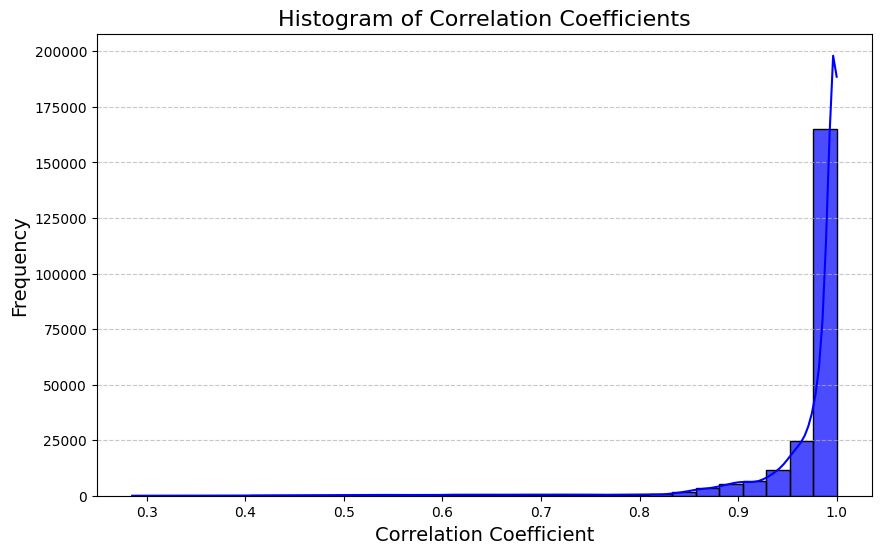

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 相関係数 'Correlation' 列が存在するか確認
if 'Correlation' in correlation_df.columns:
    # ヒストグラムをプロット
    plt.figure(figsize=(10, 6))
    sns.histplot(correlation_df['Correlation'], bins=30, kde=True, color='blue', alpha=0.7)
    plt.title("Histogram of Correlation Coefficients", fontsize=16)
    plt.xlabel("Correlation Coefficient", fontsize=14)
    plt.ylabel("Frequency", fontsize=14)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()
else:
    print("'Correlation' column not found in correlation_df.")


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# 特徴量とターゲット変数を準備
# 'Correlation' を特徴量として使用し、'Industry' をターゲット変数に設定
features = correlation_df[['Correlation']]
target = correlation_df['Industry']

# データをトレーニングセットとテストセットに分割
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# ランダムフォレスト分類モデルを構築
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# テストセットで予測
y_pred = model.predict(X_test)

# モデルの精度を評価
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Accuracy Score:", accuracy_score(y_test, y_pred))

# 重要な特徴量を確認
feature_importances = model.feature_importances_
print("Feature Importances:", feature_importances)


Classification Report:
              precision    recall  f1-score   support

       その他製品       0.10      0.09      0.09      3181
       サービス業       0.15      0.15      0.15      3219
       パルプ・紙       0.18      0.18      0.18      3227
        不動産業       0.13      0.13      0.13      3114
          化学       0.38      0.39      0.38      3189
         医薬品       0.08      0.08      0.08      3203
         卸売業       0.09      0.09      0.09      3212
         小売業       0.99      1.00      1.00      3234
      情報・通信業       0.16      0.16      0.16      3235
          機械       0.10      0.10      0.10      3275
        繊維製品       0.09      0.09      0.09      3267
        金属製品       0.14      0.15      0.15      3289
        電気機器       0.22      0.26      0.24      3223
         食料品       0.14      0.13      0.13      3240

    accuracy                           0.21     45108
   macro avg       0.21      0.21      0.21     45108
weighted avg       0.21      0.21      0.21     45108

Ac

In [ ]:
#最終日からの株価変動率
import pandas as pd
import numpy as np
from itertools import combinations

# 株価変動率を計算する関数（2日目から計算）
def calculate_return(group, stock_columns):
    returns = {}

    # 各企業ごとに株価変動率を計算（2日目から）
    for col in stock_columns:
        returns[col] = (group[col].iloc[-1] - group[col].iloc[:-1]) / group[col].iloc[:-1]

    # 最初の行（1日目）を除外して新しいDataFrameを返す
    return pd.DataFrame(returns, index=group.index[1:])

# 企業間の相関係数を計算
def calculate_correlation(group, stock_columns):
    corr_results = []

    # 業種内の企業間でペアワイズの相関係数を計算
    for (col1, col2) in combinations(stock_columns, 2):
        series1 = group[col1]
        series2 = group[col2]

        # 株価変動率が2つ以上の企業に対して相関を計算
        if len(series1) > 1 and len(series2) > 1:
            corr = np.corrcoef(series1, series2)[0, 1]
            if not np.isnan(corr):
                corr_results.append({
                    'Industry': group['提出者業種'].iloc[0],  # 同じ業種の企業からの相関を計算
                    'Company1': col1,
                    'Company2': col2,
                    'Correlation': corr
                })

    return corr_results

# 株価のカラム名リスト（企業ごとに分かれている）
stock_columns = [col for col in merged_df.columns if col.startswith('Close_')]

# 業種ごとにグループ化
grouped = merged_df.groupby('提出者業種')

# 各業種ごとの株価変動率を計算
returns_data = {}

for industry, group in grouped:
    returns_data[industry] = calculate_return(group, stock_columns)

# 株価変動率データをDataFrameに結合
returns_df = pd.concat(returns_data, axis=0)

# 企業間の相関を計算
correlation_results = []

for industry, group in grouped:
    corr_results = calculate_correlation(group, stock_columns)
    correlation_results.extend(corr_results)

# 結果をDataFrameに変換
correlation_df = pd.DataFrame(correlation_results)

# 業種間の代表的な相関係数を計算する関数
def calculate_industry_correlation(correlation_df):
    # 業種ペアごとの相関係数を計算
    industries = correlation_df['Industry'].unique()
    industry_correlation_matrix = pd.DataFrame(index=industries, columns=industries)

    for industry1 in industries:
        for industry2 in industries:
            # 同じ業種内および異業種間で相関係数を計算
            filtered_df = correlation_df[(correlation_df['Industry'] == industry1) | (correlation_df['Industry'] == industry2)]
            avg_corr = filtered_df['Correlation'].mean()
            industry_correlation_matrix.loc[industry1, industry2] = avg_corr

    return industry_correlation_matrix

# 業種間の相関係数を計算
industry_correlation_matrix = calculate_industry_correlation(correlation_df)

# 結果を表示
if not industry_correlation_matrix.empty:
    display(industry_correlation_matrix)
else:
    print("No industry correlation data available.")


,その他製品,サービス業,パルプ・紙,不動産業,化学,医薬品,卸売業,小売業,情報・通信業,機械,繊維製品,金属製品,電気機器,食料品
その他製品,0.98755,0.977323,0.971327,0.991267,0.91412,0.987613,0.988849,0.993775,0.966703,0.988181,0.981421,0.99259,0.993149,0.970876
サービス業,0.977323,0.967096,0.9611,0.98104,0.903893,0.977386,0.978622,0.983548,0.956476,0.977954,0.971195,0.982363,0.982922,0.96065
パルプ・紙,0.971327,0.9611,0.955104,0.975044,0.897897,0.97139,0.972626,0.977552,0.95048,0.971958,0.965198,0.976367,0.976926,0.954654
不動産業,0.991267,0.98104,0.975044,0.994985,0.917837,0.99133,0.992566,0.997492,0.97042,0.991898,0.985139,0.996307,0.996867,0.974594
化学,0.91412,0.903893,0.897897,0.917837,0.840689,0.914182,0.915418,0.920345,0.893272,0.914751,0.907991,0.91916,0.919719,0.897446
医薬品,0.987613,0.977386,0.97139,0.99133,0.914182,0.987675,0.988911,0.993837,0.966765,0.988243,0.981484,0.992653,0.993212,0.970939
卸売業,0.988849,0.978622,0.972626,0.992566,0.915418,0.988911,0.990147,0.995074,0.968001,0.98948,0.98272,0.993889,0.994448,0.972175
小売業,0.993775,0.983548,0.977552,0.997492,0.920345,0.993837,0.995074,1.0,0.972927,0.994406,0.987646,0.998815,0.999374,0.977101
情報・通信業,0.966703,0.956476,0.95048,0.97042,0.893272,0.966765,0.968001,0.972927,0.945855,0.967333,0.960574,0.971743,0.972302,0.950029
機械,0.988181,0.977954,0.971958,0.991898,0.914751,0.988243,0.98948,0.994406,0.967333,0.988812,0.982052,0.993221,0.99378,0.971507


In [ ]:
#最終日と当日の株価変動率
import pandas as pd
import numpy as np
from itertools import combinations

# 株価変動率を計算する関数（2日目から計算）
def calculate_return(group, stock_columns):
    returns = {}

    # 各企業ごとに株価変動率を計算（2日目から）
    for col in stock_columns:
        returns[col] = (group[col].iloc[-1] - group[col].iloc[0]) / group[col].iloc[0]

    # 最初の行（1日目）を除外して新しいDataFrameを返す
    return pd.DataFrame(returns, index=group.index[1:])

# 企業間の相関係数を計算
def calculate_correlation(group, stock_columns):
    corr_results = []

    # 業種内の企業間でペアワイズの相関係数を計算
    for (col1, col2) in combinations(stock_columns, 2):
        series1 = group[col1]
        series2 = group[col2]

        # 株価変動率が2つ以上の企業に対して相関を計算
        if len(series1) > 1 and len(series2) > 1:
            corr = np.corrcoef(series1, series2)[0, 1]
            if not np.isnan(corr):
                corr_results.append({
                    'Industry': group['提出者業種'].iloc[0],  # 同じ業種の企業からの相関を計算
                    'Company1': col1,
                    'Company2': col2,
                    'Correlation': corr
                })

    return corr_results

# 株価のカラム名リスト（企業ごとに分かれている）
stock_columns = [col for col in merged_df.columns if col.startswith('Close_')]

# 業種ごとにグループ化
grouped = merged_df.groupby('提出者業種')

# 各業種ごとの株価変動率を計算
returns_data = {}

for industry, group in grouped:
    returns_data[industry] = calculate_return(group, stock_columns)

# 株価変動率データをDataFrameに結合
returns_df = pd.concat(returns_data, axis=0)

# 企業間の相関を計算
correlation_results = []

for industry, group in grouped:
    corr_results = calculate_correlation(group, stock_columns)
    correlation_results.extend(corr_results)

# 結果をDataFrameに変換
correlation_df = pd.DataFrame(correlation_results)

# 業種間の代表的な相関係数を計算する関数
def calculate_industry_correlation(correlation_df):
    # 業種ペアごとの相関係数を計算
    industries = correlation_df['Industry'].unique()
    industry_correlation_matrix = pd.DataFrame(index=industries, columns=industries)

    for industry1 in industries:
        for industry2 in industries:
            # 同じ業種内および異業種間で相関係数を計算
            filtered_df = correlation_df[(correlation_df['Industry'] == industry1) | (correlation_df['Industry'] == industry2)]
            avg_corr = filtered_df['Correlation'].mean()
            industry_correlation_matrix.loc[industry1, industry2] = avg_corr

    return industry_correlation_matrix

# 業種間の相関係数を計算
industry_correlation_matrix = calculate_industry_correlation(correlation_df)

# 結果を表示
if not industry_correlation_matrix.empty:
    display(industry_correlation_matrix)
else:
    print("No industry correlation data available.")


,その他製品,サービス業,パルプ・紙,不動産業,化学,医薬品,卸売業,小売業,情報・通信業,機械,繊維製品,金属製品,電気機器,食料品
その他製品,0.98755,0.977323,0.971327,0.991267,0.91412,0.987613,0.988849,0.993775,0.966703,0.988181,0.981421,0.99259,0.993149,0.970876
サービス業,0.977323,0.967096,0.9611,0.98104,0.903893,0.977386,0.978622,0.983548,0.956476,0.977954,0.971195,0.982363,0.982922,0.96065
パルプ・紙,0.971327,0.9611,0.955104,0.975044,0.897897,0.97139,0.972626,0.977552,0.95048,0.971958,0.965198,0.976367,0.976926,0.954654
不動産業,0.991267,0.98104,0.975044,0.994985,0.917837,0.99133,0.992566,0.997492,0.97042,0.991898,0.985139,0.996307,0.996867,0.974594
化学,0.91412,0.903893,0.897897,0.917837,0.840689,0.914182,0.915418,0.920345,0.893272,0.914751,0.907991,0.91916,0.919719,0.897446
医薬品,0.987613,0.977386,0.97139,0.99133,0.914182,0.987675,0.988911,0.993837,0.966765,0.988243,0.981484,0.992653,0.993212,0.970939
卸売業,0.988849,0.978622,0.972626,0.992566,0.915418,0.988911,0.990147,0.995074,0.968001,0.98948,0.98272,0.993889,0.994448,0.972175
小売業,0.993775,0.983548,0.977552,0.997492,0.920345,0.993837,0.995074,1.0,0.972927,0.994406,0.987646,0.998815,0.999374,0.977101
情報・通信業,0.966703,0.956476,0.95048,0.97042,0.893272,0.966765,0.968001,0.972927,0.945855,0.967333,0.960574,0.971743,0.972302,0.950029
機械,0.988181,0.977954,0.971958,0.991898,0.914751,0.988243,0.98948,0.994406,0.967333,0.988812,0.982052,0.993221,0.99378,0.971507


In [ ]:
import pandas as pd
import numpy as np

# 180日分の変動率を計算する関数
def calculate_correlation(group1, group2, stock_columns):
    if group1[stock_columns].shape[0] > 1 and group2[stock_columns].shape[0] > 1:
        # 180日分の株価の変動率を計算
        returns1 = (group1[stock_columns].iloc[-1] - group1[stock_columns].iloc[0]) / group1[stock_columns].iloc[0]
        returns2 = (group2[stock_columns].iloc[-1] - group2[stock_columns].iloc[0]) / group2[stock_columns].iloc[0]

        # 2つの企業間での相関係数を計算
        correlation_matrix = returns1.corr(returns2)

        # 相関係数の平均値を取得
        avg_correlation = correlation_matrix.mean()
        return avg_correlation
    else:
        return np.nan  # データが1行だけの場合はNaNを返す

# 株価のカラム名リストを動的に作成
stock_columns = [col for col in merged_df.columns if col.startswith('Close_')]

# 業種ごとのグループ化
grouped = merged_df.groupby('提出者業種')

# 業種ごとのデータをすべて計算するためにフィルタリングを外す
valid_industries = list(grouped.groups.keys())  # 全ての業種を対象

# すべての業種間で相関を計算
industry_combinations = []  # 結果を格納するリストを再定義

# 業種ペアの相関を計算（同じ業種も含む）
for industry1 in valid_industries:
    for industry2 in valid_industries:
        group1 = grouped.get_group(industry1)
        group2 = grouped.get_group(industry2)

        # データが2行以上あるかを確認してから相関を計算
        if group1.shape[0] > 1 and group2.shape[0] > 1:
            avg_correlation = calculate_correlation(group1, group2, stock_columns=stock_columns)
            if not np.isnan(avg_correlation):
                industry_combinations.append({
                    'Industry1': industry1,
                    'Industry2': industry2,
                    'Avg_Correlation': avg_correlation
                })

# 結果をデータフレームに変換
industry_correlation_df = pd.DataFrame(industry_combinations)

# 結果を表示
print("industry_correlation_df:")
print(industry_correlation_df)  # 出力内容を確認

# 結果をpivotテーブルで整形し、相関行列を表示
if not industry_correlation_df.empty:
    # 'Industry1'を行、'Industry2'を列、'Avg_Correlation'を値にしてpivotテーブルを作成
    industry_correlation_matrix = industry_correlation_df.pivot_table(
        index='Industry1',
        columns='Industry2',
        values='Avg_Correlation',
        aggfunc='mean'
    )

    print("Industry Correlation Matrix:")
    display(industry_correlation_matrix)
else:
    print("industry_correlation_df is empty. No correlation data available.")


ストリーミング出力は最後の 5000 行に切り捨てられました。
      Close_174    Close_175    Close_176    Close_177    Close_178  \
16   850.734497   843.990234   850.734497   849.770996   848.807556   
40  2106.751221  2044.444458  2001.608398  2033.735352  2063.915283   
43  2299.467529  2316.116211  2299.467529  2357.248047  2368.020752   

      Close_179    Close_180  \
16   844.953735   849.770996   
40  2095.068848  2130.116455   
43  2399.359131  2480.643555   

                                          text_vector  stock_return  
16  [-0.47671896, 0.6309291, 0.08142841, -0.211036...      0.000675  
40  [-0.54192704, 0.5290647, 0.23671769, -0.208283...      0.001143  
43  [-0.31779245, 0.5454206, -0.23425336, -0.30728...      0.002683  

[3 rows x 187 columns] and                  会社名  証券コード         提出日 提出者業種  \
2   ロイヤルホールディングス株式会社  81790  2023-03-30   小売業   
55  株式会社フジオフードグループ本社  27520  2023-03-30   小売業   

                                                 テキスト      Close_1  \
2   当社グループ当社及び当社の関係会社は、当社、子会

Industry2,その他製品,サービス業,パルプ・紙,不動産業,化学,医薬品,卸売業,小売業,情報・通信業,機械,繊維製品,金属製品,電気機器,食料品
Industry1,,,,,,,,,,,,,,
その他製品,1.000000,-0.258278,0.161579,-0.393571,-0.599201,-0.608814,-0.048322,0.452086,-0.020568,0.430118,0.511016,0.369632,0.470709,0.514112
サービス業,-0.258278,1.000000,-0.526953,0.063095,0.480918,0.593784,0.254642,-0.250723,0.061533,-0.470224,-0.571863,-0.585183,0.053163,-0.434225
パルプ・紙,0.161579,-0.526953,1.000000,-0.262272,-0.764349,-0.769325,-0.118778,0.318331,-0.498010,0.842503,0.677440,0.768688,0.091285,0.587636
不動産業,-0.393571,0.063095,-0.262272,1.000000,0.654884,0.552748,-0.606897,-0.513820,-0.217942,-0.637665,-0.650108,-0.249689,-0.497725,-0.830225
化学,-0.599201,0.480918,-0.764349,0.654884,1.000000,0.939581,-0.162240,-0.668337,0.162109,-0.952107,-0.890834,-0.719416,-0.453692,-0.883102
医薬品,-0.608814,0.593784,-0.769325,0.552748,0.939581,1.000000,-0.007664,-0.571710,0.214874,-0.907345,-0.901823,-0.795718,-0.306194,-0.847726
卸売業,-0.048322,0.254642,-0.118778,-0.606897,-0.162240,-0.007664,1.000000,0.329935,0.340970,0.177260,0.066612,-0.325170,0.543437,0.297706
小売業,0.452086,-0.250723,0.318331,-0.513820,-0.668337,-0.571710,0.329935,1.000000,0.328800,0.605806,0.527316,0.217546,0.525617,0.556557
情報・通信業,-0.020568,0.061533,-0.498010,-0.217942,0.162109,0.214874,0.340970,0.328800,1.000000,-0.219314,-0.029530,-0.492949,0.207592,0.044624


In [ ]:
import pandas as pd
import numpy as np

# 180日分の変動率を計算する関数（diffを使わない）
def calculate_correlation(group1, group2, stock_columns):
    if group1[stock_columns].shape[0] > 1 and group2[stock_columns].shape[0] > 1:
        # 180日分の株価の変動率を計算
        returns1 = (group1[stock_columns].iloc[-1] - group1[stock_columns].iloc[0]) / group1[stock_columns].iloc[0]
        returns2 = (group2[stock_columns].iloc[-1] - group2[stock_columns].iloc[0]) / group2[stock_columns].iloc[0]

        # 2つの業種間での相関係数を計算
        correlation_matrix = returns1.corr(returns2)

        # 相関係数の平均値を取得
        avg_correlation = correlation_matrix.mean()
        return avg_correlation
    else:
        return np.nan  # データが1行だけの場合はNaNを返す

# 株価のカラム名リストを動的に作成
stock_columns = [col for col in merged_df.columns if col.startswith('Close_')]

# 業種ごとのデータをすべて計算するためにフィルタリングを外す
valid_industries = list(grouped.groups.keys())  # 全ての業種を対象

# すべての業種間で相関を計算
industry_combinations = []  # 結果を格納するリストを再定義

# 業種ペアの相関を計算（同じ業種も含む）
for industry1 in valid_industries:
    for industry2 in valid_industries:
        group1 = grouped.get_group(industry1)
        group2 = grouped.get_group(industry2)

        # データが2行以上あるかを確認してから相関を計算
        if group1.shape[0] > 1 and group2.shape[0] > 1:
            avg_correlation = calculate_correlation(group1, group2, stock_columns=stock_columns)
            if not np.isnan(avg_correlation):
                industry_combinations.append({
                    'Industry1': industry1,
                    'Industry2': industry2,
                    'Avg_Correlation': avg_correlation
                })

# 結果をデータフレームに変換
industry_correlation_df = pd.DataFrame(industry_combinations)

# 結果を表示
print("industry_correlation_df:")
print(industry_correlation_df)  # 出力内容を確認

# 結果をpivotテーブルで整形し、相関行列を表示
if not industry_correlation_df.empty:
    # 'Industry1'を行、'Industry2'を列、'Avg_Correlation'を値にしてpivotテーブルを作成
    industry_correlation_matrix = industry_correlation_df.pivot_table(
        index='Industry1',
        columns='Industry2',
        values='Avg_Correlation',
        aggfunc='mean'
    )

    print("Industry Correlation Matrix:")
    display(industry_correlation_matrix)
else:
    print("industry_correlation_df is empty. No correlation data available.")



industry_correlation_df:
    Industry1 Industry2  Avg_Correlation
0       その他製品     その他製品         1.000000
1       その他製品     サービス業        -0.258278
2       その他製品     パルプ・紙         0.161579
3       その他製品      不動産業        -0.393571
4       その他製品        化学        -0.599201
..        ...       ...              ...
191       食料品        機械         0.859409
192       食料品      繊維製品         0.906217
193       食料品      金属製品         0.583188
194       食料品      電気機器         0.422717
195       食料品       食料品         1.000000

[196 rows x 3 columns]
Industry Correlation Matrix:


Industry2,その他製品,サービス業,パルプ・紙,不動産業,化学,医薬品,卸売業,小売業,情報・通信業,機械,繊維製品,金属製品,電気機器,食料品
Industry1,,,,,,,,,,,,,,
その他製品,1.000000,-0.258278,0.161579,-0.393571,-0.599201,-0.608814,-0.048322,0.452086,-0.020568,0.430118,0.511016,0.369632,0.470709,0.514112
サービス業,-0.258278,1.000000,-0.526953,0.063095,0.480918,0.593784,0.254642,-0.250723,0.061533,-0.470224,-0.571863,-0.585183,0.053163,-0.434225
パルプ・紙,0.161579,-0.526953,1.000000,-0.262272,-0.764349,-0.769325,-0.118778,0.318331,-0.498010,0.842503,0.677440,0.768688,0.091285,0.587636
不動産業,-0.393571,0.063095,-0.262272,1.000000,0.654884,0.552748,-0.606897,-0.513820,-0.217942,-0.637665,-0.650108,-0.249689,-0.497725,-0.830225
化学,-0.599201,0.480918,-0.764349,0.654884,1.000000,0.939581,-0.162240,-0.668337,0.162109,-0.952107,-0.890834,-0.719416,-0.453692,-0.883102
医薬品,-0.608814,0.593784,-0.769325,0.552748,0.939581,1.000000,-0.007664,-0.571710,0.214874,-0.907345,-0.901823,-0.795718,-0.306194,-0.847726
卸売業,-0.048322,0.254642,-0.118778,-0.606897,-0.162240,-0.007664,1.000000,0.329935,0.340970,0.177260,0.066612,-0.325170,0.543437,0.297706
小売業,0.452086,-0.250723,0.318331,-0.513820,-0.668337,-0.571710,0.329935,1.000000,0.328800,0.605806,0.527316,0.217546,0.525617,0.556557
情報・通信業,-0.020568,0.061533,-0.498010,-0.217942,0.162109,0.214874,0.340970,0.328800,1.000000,-0.219314,-0.029530,-0.492949,0.207592,0.044624


In [ ]:
import pandas as pd
import numpy as np
from itertools import combinations
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sentence_transformers import SentenceTransformer

# 株価変動率を計算する関数（2日目から計算）
def calculate_return(group, stock_columns):
    returns = {}
    for col in stock_columns:
        returns[col] = (group[col].iloc[1:] - group[col].iloc[:-1]) / group[col].iloc[:-1]
    return pd.DataFrame(returns, index=group.index[1:])

# 株価のカラム名リスト（企業ごとに分かれている）
stock_columns = [col for col in merged_df.columns if col.startswith('Close_')]

# 提出者業種でグループ化
grouped = merged_df.groupby('提出者業種')

# 各企業の株価変動率を計算
returns_data = {}
for industry, group in grouped:
    returns_data[industry] = calculate_return(group, stock_columns)

# 株価変動率データをDataFrameに結合
returns_df = pd.concat(returns_data, axis=0)

# 事業内容をベクトル化
model = SentenceTransformer('all-MiniLM-L6-v2')  # モデルを指定
business_descriptions = merged_df['テキスト'].tolist()  # 事業内容をリストに変換
company_text = model.encode(business_descriptions)  # 事業内容をベクトル化

# 特徴量（テキストベクトル + 他の株価変動率）を結合
X_features = np.hstack([company_text, returns_df.values])

# 株価変動率の予測対象（例：次の期の株価変動率を予測）
y = returns_df.shift(-1)  # 次の期の変動率をターゲットにする

# データを訓練用とテスト用に分ける
X_train, X_test, y_train, y_test = train_test_split(X_features, y, test_size=0.2, random_state=42)

# 線形回帰モデルで学習
model = LinearRegression()
model.fit(X_train, y_train)

# テストデータで予測
y_pred = model.predict(X_test)

# 評価（平均二乗誤差）
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

# 予測結果を表示（例: 最初の5件）
predicted_vs_actual = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_pred.flatten()})
print(predicted_vs_actual.head())

# 相関係数の計算
correlation_results = []
for company1, company2 in combinations(merged_df.index, 2):
    company1_returns = returns_df.loc[company1]
    company2_returns = returns_df.loc[company2]

    # 相関係数を計算
    correlation = np.corrcoef(company1_returns, company2_returns)[0, 1]
    correlation_results.append([company1, company2, correlation])

# 結果をデータフレームにまとめる
correlation_df = pd.DataFrame(correlation_results, columns=['Company1', 'Company2', 'Correlation'])
print(correlation_df.head())


ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 79 and the array at index 1 has size 61

In [ ]:
import numpy as np

# 相関値が一定範囲に偏らないように調整
positive_samples = y[np.abs(y) > 0.5]  # 例: 相関値が0.5以上のデータを抽出
negative_samples = y[np.abs(y) <= 0.5]  # 残りのデータ
y = np.concatenate([positive_samples, negative_samples[:len(positive_samples)]])


In [ ]:
import numpy as np
from itertools import combinations
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
from sklearn.linear_model import HuberRegressor
from sklearn.linear_model import Ridge

# 株価相関行列と特徴量からデータセットを作成
X, y = prepare_data(merged_df, company_text,correlations)

# Fisher Z変換を適用
#y = np.arctanh(y)  # 相関が -1~1 の範囲にある前提

# 対数変換 (0の値に小さな定数を加える)
#y = np.sign(y) * np.log1p(np.abs(y))

# データ分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# サンプル重みを計算
#weights = 1 / np.abs(y_train + 1e-8)

# Huber Regressorのモデルを定義
#huber = HuberRegressor(epsilon=1.35)  # epsilonを調整することで外れ値の影響を変更可能

# モデルの学習
#huber.fit(X_train, y_train)


# モデル構築と学習
model = LinearRegression()
model.fit(X_train, y_train)


IndexError: index 1 is out of bounds for axis 0 with size 1

In [ ]:
# モデル評価
def evaluate_model(y_test, y_pred):
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mbe = np.mean(y_test - y_pred)
    return mse, mae, rmse, mbe

# 予測と評価
y_pred = model.predict(X_test)
mse, mae, rmse, mbe = evaluate_model(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"Root Mean Squared Error: {rmse}")
print(f"Mean Bias Error: {mbe}")

# 可視化
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlim([min(y_test), max(y_test)])
plt.ylim([min(y_test), max(y_test)])
plt.xlabel("Actual Correlations")
plt.ylabel("Predicted Correlations")
plt.title("Actual vs Predicted Correlations")
plt.show()

ValueError: X has 769 features, but LinearRegression is expecting 3031 features as input.

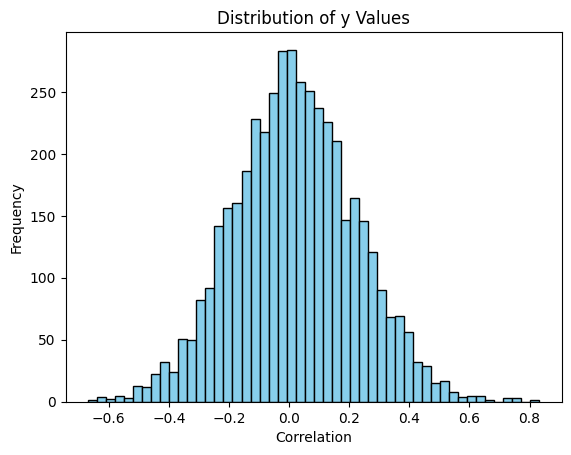

In [ ]:
import matplotlib.pyplot as plt

# 相関値のヒストグラムを表示
plt.hist(y, bins=50, color='skyblue', edgecolor='black')
plt.title("Distribution of y Values")
plt.xlabel("Correlation")
plt.ylabel("Frequency")
plt.show()


In [ ]:
#株価変動率とテキストが特徴量,株価変動率の相関が目的変数

# 株価データの変動率を計算
stock_returns = (stock_prices[:, 1:] - stock_prices[:, :-1]) / stock_prices[:, :-1]
correlations = np.corrcoef(stock_returns.T, rowvar=False)

# 株価変動率特徴量とテキスト特徴量の結合
def prepare_data(merged_df, company_text, correlations, stock_returns):
    X_list, y = [], []
    for i, j in combinations(range(len(merged_df)), 2):
        text_features = np.hstack([company_text[i], company_text[j]])
        stock_features = np.hstack([stock_returns[i], stock_returns[j]])
        X_list.append(np.hstack([text_features, stock_features]))
        y.append(correlations[i, j])
    return np.array(X_list), np.array(y)

# 株価相関行列と特徴量からデータセットを作成
X, y = prepare_data(merged_df, company_text, correlations, stock_returns)

In [ ]:
#テキストのみ特徴量,絶対株価の相関係数が目的変数

# 株価の相関を計算
correlations = np.corrcoef(stock_prices.T, rowvar=False)
display(correlations)

def prepare_data(merged_df, company_text, correlations):
    X_list, y = [], []
    for i, j in combinations(range(len(merged_df)), 2):
        X_list.append(np.hstack([company_text[i].flatten(), company_text[j].flatten()]))
        y.append(correlations[i,j])
    return np.array(X_list), np.array(y)

# 株価相関行列と特徴量からデータセットを作成
X, y = prepare_data(merged_df, company_text,correlations)

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# 株価の相関を計算
correlations = calculate_correlations(stock_prices)

# 相関行列の上三角部分（企業間の相関を取り出す）
# 企業間のペアごとに相関を取り出す
y = []
X_list = []

for i in range(len(merged_df)):
    for j in range(i + 1, len(merged_df)):
        # 事業内容特徴量のペアを取り出す
        X_list.append(np.hstack([X_text[i].flatten(), X_text[j].flatten()]))
        # 株価相関のペアの値をyに追加
        y.append(correlations[i, j])

X = np.array(X_list)
y = np.array(y)

# 4. 学習用データとテスト用データに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 5. モデルの作成
model = LinearRegression()
model.fit(X_train, y_train)

# 6. テストデータを使って予測
y_pred = model.predict(X_test)

# 7. 複数の評価
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
mae = np.mean(np.abs(y_test - y_pred))
print(f"Mean Absolute Error: {mae}")
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error: {rmse}")


Mean Squared Error: 0.20372274019293
Mean Absolute Error: 0.3574916769487157
Root Mean Squared Error: 0.4513565555001168


In [ ]:
import numpy as np

# '調整日' をインデックスにして '会社名' を列に、'終値' を値とするピボットテーブルを作成
pivot_data = df.pivot_table(index='提出日', columns='会社名', values='終値')
# 株価の相関行列を計算
correlation_matrix = pivot_data.corr()

# ターゲット変数として特定の企業間の相関を設定（例: '企業A' と '企業B'）
company_a = "一正蒲鉾株式会社"
company_b = "株式会社ジョイフル本田"
if company_a in correlation_matrix.columns and company_b in correlation_matrix.columns:
    correlation_target = correlation_matrix.loc[company_a, company_b]
else:
    raise ValueError(f"{company_a} or {company_b} not found in the correlation matrix.")

correlation_target

nan